In [1]:
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib
import skimage.io as io
import seaborn as sns; sns.set_context("talk")
font = {'size'   : 16, 'weight' : 'normal', 'family' : 'arial'}
matplotlib.rc('font', **font)

def xlsx2D_to_df1D(xlsx_path, sheet, data_col):
    df = pd.read_excel(xlsx_path, sheet_name=sheet, index_col=0)
    df = df.unstack().reset_index(name=data_col) # unpivot (linearize) the table
    df.rename(columns={'level_1': 'antigen_row', 'level_0': 'antigen_col'}, inplace=True)
    df = df[['antigen_row', 'antigen_col', data_col]]
    return df
    

# Setup

*  xkappa biotin spots: these spots are coated with human kappa light chain conjugated to biotin, so that when the streptavidin-HRP is added there is strong signal independent of the serum content.  **We should not expect the fiducial signal to weaken with serial dilution.**
*  Row-5 (row index 4) in multiple wells shows excessive comets and are not interpretable. The row corresponds to concentration range of (SARS-CoV2-RBD).  
*  Looking at debug plots, following spots are not reliable:
 * A1: row-4, (5,1)
 * B1: row-4, (5,1)
 * C3: whole well
 * D3: whole well
 * E3: whole well
 * E11: whole well


## Set paths

In [108]:
data_folder=r'/Volumes/GoogleDrive/My Drive/ELISAarrayReader/images_scienion/2020-04-08-14-48-49-COVID_concentrationtest_April8_images'
plateinfo_path=os.path.join(data_folder,'COVIDplateinfo0408_v2.xlsx')
antigenOD_path=os.path.join(data_folder,'python_fit_ODs.xlsx') 
python_int_path=os.path.join(data_folder,'python_fit_intensities.xlsx') 
python_bg_path=os.path.join(data_folder,'python_fit_backgrounds.xlsx')
antigens_path=os.path.join(data_folder,'python_antigens.xlsx')
scienionpath=os.path.join(data_folder,'2020-04-08-14-57-09-COVID_concentrationtest_April8_analysis2.xlsx')


# Read antigen and plate info

In [161]:

sheet_names = ['serum ID', 'dilution', 'type']
plate_info_df = pd.DataFrame()
for sheet_name in sheet_names:
    
    sheet_df = pd.read_excel(plateinfo_path, sheet_name=sheet_name, index_col=0)
    sheet_df = sheet_df.unstack().reset_index(name=sheet_name) # unpivot (linearize) the table
    sheet_df.rename(columns={'level_1': 'row_id', 'level_0': 'col_id'}, inplace=True)
    if sheet_name == 'serum ID':
        plate_info_df = sheet_df
    else:
        plate_info_df = pd.merge(plate_info_df,
                                 sheet_df,
                                 how='left', on=['row_id', 'col_id'])       
plate_info_df['well_id'] = plate_info_df.row_id + plate_info_df.col_id.map(str)
plate_info_df['dilution'] = 1 / plate_info_df['dilution']  
plate_info_df = plate_info_df[['serum ID', 'dilution', 'type', 'well_id']]
plate_info_df.dropna(inplace=True)
# plate_info_df.rename(columns={'Well': 'well_id', 'Type':'type', 'Dilution':'dilution'}, inplace=True)

# # serum_day_df=plate_info_df['Sera ID'].str.split('-Day', expand=True) #If sera names are not organized by ID+collection day, comment out
# #serum_day_df.fillna(0, inplace=True)
# #serum_day_df.columns=['serum', 'day']
# #serum_day_df['day'] = serum_day_df['day'].astype(int)
# #plate_info_df = pd.concat([plate_info_df, serum_day_df], axis=1)
# #plate_info_df.drop(['Sera ID'], axis=1, inplace=True)
# plate_info_df['type'] = plate_info_df['Sera ID'].str.replace(' \d+', '')
# # print(plate_info_df[plate_info_df['Sera ID']=='pos 1']['dilution'].unique())
plate_info_df

serum ID  dilution type well_id
0     pos 1  0.020000  pos      A1
1     pos 1  0.005000  pos      B1
2     pos 1  0.001250  pos      C1
3     pos 1  0.000313  pos      D1
4     pos 1  0.000078  pos      E1
..      ...       ...  ...     ...
87   neg 15  0.000039  neg     H11
88    neg 8  0.020000  neg     A12
89    neg 8  0.002500  neg     B12
90    neg 8  0.000313  neg     C12
91    neg 8  0.000039  neg     D12

[92 rows x 4 columns]

In [117]:
antigen_df = xlsx2D_to_df1D(xlsx_path=antigens_path, sheet='antigens', data_col='antigen')   
antigen_df

antigen_row  antigen_col              antigen
0             0            0        xkappa-biotin
1             1            0        xkappa-biotin
2             2            0              xIgG Fc
3             3            0              xIgG Fc
4             4            0           GFP foldon
5             5            0        xkappa-biotin
6             0            1             HA H1 MI
7             1            1         MERS RBD-500
8             2            1         SARS RBD-500
9             3            1     SARS CoV2 RBD-80
10            4            1      SARS CoV2 N-500
11            5            1  SARS CoV2 Spike-160
12            0            2             HA H1 MI
13            1            2         MERS RBD-250
14            2            2         SARS RBD-250
15            3            2    SARS CoV2 RBD-250
16            4            2      SARS CoV2 N-250
17            5            2  SARS CoV2 Spike-160
18            0            3             HA H1 MI
19            1            3         MERS RBD-250
20            2            3         SARS RBD-250
21            3            3    SARS CoV2 RBD-250
22            4            3      SARS CoV2 N-250
23            5            3  SARS CoV2 Spike-160
24            0            4             HA H1 MI
25            1            4         MERS RBD-100
26            2            4         SARS RBD-100
27            3            4    SARS CoV2 RBD-100
28            4            4      SARS CoV2 N-100
29            5            4  SARS CoV2 Spike-160
30            0            5        xkappa-biotin
31            1            5         MERS RBD-100
32            2            5         SARS RBD-100
33            3            5    SARS CoV2 RBD-100
34            4            5      SARS CoV2 N-100
35            5            5        xkappa-biotin

# Read analysis output from Scienion 

In [123]:
# Read all wells into dictionary. 
scienion_df = pd.DataFrame()
for well_id in plate_info_df['well_id']:
    OD_1_well_df = pd.read_excel(scienionpath, sheet_name=well_id)
    OD_1_well_df['well_id'] = well_id
    scienion_df = scienion_df.append(OD_1_well_df, ignore_index=True)

scienion_df[0:20]
# scienion_df.shape

ID  X [µm]  Y [µm]      Result  \
0   spot-1-2  2851.0  4002.0    Positive   
1   spot-1-3  3237.0  3978.0    Positive   
2   spot-1-4  3622.0  3975.0    Positive   
3   spot-1-5  4057.0  4000.0    Positive   
4   spot-2-2  2861.0  4398.0    Positive   
5   spot-2-3  3223.0  4409.0    Positive   
6   spot-2-4  3645.0  4431.0    Positive   
7   spot-2-5  4038.0  4439.0    Positive   
8   spot-2-6  4456.0  4411.0    Positive   
9   spot-3-1  2452.0  4805.0    Positive   
10  spot-3-2  2784.0  4737.0  Borderline   
11  spot-3-3  3373.0  4656.0    Positive   
12  spot-3-4  3703.0  4880.0    Positive   
13  spot-3-5  4063.0  4751.0    Negative   
14  spot-3-6  4445.0  4848.0    Positive   
15  spot-4-1  2459.0  5283.0    Positive   
16  spot-4-2  2849.0  5160.0    Negative   
17  spot-4-3  3189.0  4979.0    Positive   
18  spot-4-4  3659.0  5160.0    Positive   
19  spot-4-5  4063.0  5160.0    Positive   

    Intensity (median, background corrected) [AU]  \
0                                          51.841   
1                                          52.960   
2                                          47.950   
3                                          48.531   
4                                          19.580   
5                                          21.739   
6                                          17.030   
7                                          20.193   
8                                          32.812   
9                                          83.629   
10                                          6.072   
11                                         14.273   
12                                         11.072   
13                                          0.738   
14                                         10.696   
15                                         10.402   
16                                          0.000   
17                                         11.506   
18                                         11.480   
19                                         19.854   

    Analyte level (median) [U/ml]  Diameter [µm]  Area [µm²]  Saturation  \
0                             NaN          159.0     19884.0         0.0   
1                             NaN          174.0     23647.0         0.0   
2                             NaN          184.0     26531.0         0.0   
3                             NaN          159.0     19799.0         0.0   
4                             NaN          185.0     26891.0         0.0   
5                             NaN          230.0     41449.0         0.0   
6                             NaN          226.0     40180.0         0.0   
7                             NaN          229.0     41268.0         0.0   
8                             NaN          180.0     25581.0         0.0   
9                             NaN          136.0     14536.0         0.0   
10                            NaN          238.0     44660.0         0.0   
11                            NaN          109.0      9307.0         0.0   
12                            NaN          298.0     69680.0         0.0   
13                            NaN          200.0     31382.0         0.0   
14                            NaN          298.0     69874.0         0.0   
15                            NaN          281.0     61938.0         0.0   
16                            NaN          200.0     31348.0         0.0   
17                            NaN           99.0      7636.0         0.0   
18                            NaN          200.0     31348.0         0.0   
19                            NaN          200.0     31348.0         0.0   

       Mean   Median  StdDev      Min      Max  Background Mean  \
0   131.123  134.597  14.249   92.045  158.345           85.759   
1   132.582  135.677  13.112   96.388  157.991           85.327   
2   127.449  130.359  12.474   90.242  152.734           85.361   
3   124.422  128.668  13.636   89.092  146.738           82.154   
4   102.924  102.904   7.711   81.353  

In [124]:
# parse spot ids
spot_id_df=scienion_df['ID'].str.extract(r'spot-(\d)-(\d)')
spot_id_df = spot_id_df.astype(int) - 1 # index starting from 0
spot_id_df.rename(columns={0: 'antigen_row', 1: 'antigen_col'}, inplace=True)

scienion_df = pd.concat([spot_id_df, scienion_df], axis=1)
scienion_df.drop('ID', axis=1, inplace=True)
scienion_df

antigen_row  antigen_col  X [µm]  Y [µm]    Result  \
0               0            1  2851.0  4002.0  Positive   
1               0            2  3237.0  3978.0  Positive   
2               0            3  3622.0  3975.0  Positive   
3               0            4  4057.0  4000.0  Positive   
4               1            1  2861.0  4398.0  Positive   
...           ...          ...     ...     ...       ...   
2971            4            5     NaN     NaN       NaN   
2972            5            1  3253.0  5912.0  Negative   
2973            5            2  3659.0  5912.0  Negative   
2974            5            3  4064.0  5912.0  Negative   
2975            5            4  4468.0  5912.0  Negative   

      Intensity (median, background corrected) [AU]  \
0                                            51.841   
1                                            52.960   
2                                            47.950   
3                                            48.531   
4                                            19.580   
...                                             ...   
2971                                            NaN   
2972                                          0.783   
2973                                          0.000   
2974                                          0.782   
2975                                          0.291   

      Analyte level (median) [U/ml]  Diameter [µm]  Area [µm²]  Saturation  \
0                               NaN          159.0     19884.0         0.0   
1                               NaN          174.0     23647.0         0.0   
2                               NaN          184.0     26531.0         0.0   
3                               NaN          159.0     19799.0         0.0   
4                               NaN          185.0     26891.0         0.0   
...                             ...            ...         ...         ...   
2971                            NaN            NaN         NaN         NaN   
2972                            NaN          200.0     31382.0         0.0   
2973                            NaN          200.0     31382.0         0.0   
2974                            NaN          200.0     31382.0         0.0   
2975                            NaN          200.0     31382.0         0.0   

      ...   Median  StdDev     Min      Max  Background Mean  \
0     ...  134.597  14.249  92.045  158.345           85.759   
1     ...  135.677  13.112  96.388  157.991           85.327   
2     ...  130.359  12.474  90.242  152.734           85.361   
3     ...  128.668  13.636  89.092  146.738           82.154   
4     ...  102.904   7.711  81.353  135.600           86.144   
...   ...      ...     ...     ...      ...              ...   
2971  ...      NaN     NaN     NaN      NaN              NaN   
2972  ...   74.770   1.703  69.784   78.977           74.013   
2973  ...   73.999   1.717  68.377   78.544           74.031   
2974  ...   75.255  11.706  69.630  131.030           76.221   
2975  ...   73.725   1.780  68.140   77.842           73.536   

      Background Median  Background StdDev  Background Min  Background Max  \
0                82.756              7.411          77.547         120.599   
1                82.717              7.095          76.596         120.873   
2                82.410              7.797          75.833         124.732   
3                80.137              6.251          74.815         117.292   
4                83.323              7.876          76.337         120.308   
...                 ...                ...             ...             ...   
2971                NaN                NaN             NaN             NaN   
2972             73.987              1.751          68.397          80.548   
2973             74.041              1.639          69.086          79.947   
2974             74.474              8.174          68.183         133.758   
2975             73.434              1.737          68.688  

In [162]:
# invert the intensity and compute ODs, check A2
df_scn = scienion_df.loc[:, ['antigen_row', 'antigen_col', 'well_id']]
df_scn['intensity'] = 1 - scienion_df['Median'] / 255
df_scn['background'] = 1 - scienion_df['Background Median'] / 255
df_scn['OD'] = np.log10(df_scn['background'] / df_scn['intensity'])
df_scn[df_scn['well_id']=='A1']

antigen_row  antigen_col well_id  intensity  background        OD
0             0            1      A1   0.472169    0.675467  0.155507
1             0            2      A1   0.467933    0.675620  0.159518
2             0            3      A1   0.488788    0.676824  0.141355
3             0            4      A1   0.495420    0.685737  0.141185
4             1            1      A1   0.596455    0.673243  0.052594
5             1            2      A1   0.582051    0.667302  0.059361
6             1            3      A1   0.589310    0.656098  0.046625
7             1            4      A1   0.594486    0.673675  0.054308
8             1            5      A1   0.551318    0.679992  0.091102
9             2            0      A1   0.339431    0.667384  0.293624
10            2            1      A1   0.617255    0.641067  0.016439
11            2            2      A1   0.602792    0.658765  0.038563
12            2            3      A1   0.599196    0.642616  0.030382
13            2            4      A1   0.663106    0.666000  0.001891
14            2            5      A1   0.625067    0.667016  0.028210
15            3            0      A1   0.476651    0.517447  0.035665
16            3            1      A1   0.562855    0.502200 -0.049520
17            3            2      A1   0.532353    0.577475  0.035333
18            3            3      A1   0.554200    0.599220  0.033919
19            3            4      A1   0.564824    0.642682  0.056084
20            3            5      A1   0.458012    0.649255  0.151539
21            4            0      A1   0.436149    0.526925  0.082114
22            4            1      A1   0.270102    0.351392  0.114264
23            4            2      A1   0.343565    0.505780  0.167953
24            4            3      A1   0.311510    0.548196  0.245464
25            4            4      A1   0.267784    0.536733  0.301973
26            4            5      A1   0.288149    0.670227  0.366605
27            5            1      A1   0.303514    0.649816  0.330612
28            5            2      A1   0.353369    0.670141  0.277938
29            5            3      A1   0.287643    0.664592  0.363701
30            5            4      A1   0.289847    0.654855  0.353976

### Join Scienion data with plateInfo

In [163]:
df_scn = pd.merge(df_scn,
                 antigen_df,
                 how='left', on=['antigen_row', 'antigen_col'])
df_scn = pd.merge(df_scn,
                 plate_info_df,
                 how='right', on=['well_id'])


In [165]:
df_scn['pipeline'] = 'scienion'
df_scn

antigen_row  antigen_col well_id  intensity  background        OD  \
0               0            1      A1   0.472169    0.675467  0.155507   
1               0            2      A1   0.467933    0.675620  0.159518   
2               0            3      A1   0.488788    0.676824  0.141355   
3               0            4      A1   0.495420    0.685737  0.141185   
4               1            1      A1   0.596455    0.673243  0.052594   
...           ...          ...     ...        ...         ...       ...   
2847            4            5     D12   0.710992    0.713647  0.001619   
2848            5            1     D12   0.708820    0.708976  0.000096   
2849            5            2     D12   0.713184    0.713431  0.000150   
2850            5            3     D12   0.713776    0.713804  0.000017   
2851            5            4     D12   0.714090    0.714882  0.000482   

                  antigen serum ID  dilution type  pipeline  
0                HA H1 MI    pos 1  0.020000  pos  scienion  
1                HA H1 MI    pos 1  0.020000  pos  scienion  
2                HA H1 MI    pos 1  0.020000  pos  scienion  
3                HA H1 MI    pos 1  0.020000  pos  scienion  
4            MERS RBD-500    pos 1  0.020000  pos  scienion  
...                   ...      ...       ...  ...       ...  
2847      SARS CoV2 N-100    neg 8  0.000039  neg  scienion  
2848  SARS CoV2 Spike-160    neg 8  0.000039  neg  scienion  
2849  SARS CoV2 Spike-160    neg 8  0.000039  neg  scienion  
2850  SARS CoV2 Spike-160    neg 8  0.000039  neg  scienion  
2851  SARS CoV2 Spike-160    neg 8  0.000039  neg  scienion  

[2852 rows x 11 columns]

# Read output from pysero

## Read optical density

In [128]:
# Read all wells into dictionary and into a 4D numpy array.
OD_df = pd.DataFrame()
for well_id in plate_info_df['well_id']:
    OD_1_well_df = xlsx2D_to_df1D(xlsx_path=antigenOD_path, sheet=well_id, data_col='OD')   
    OD_1_well_df['well_id'] = well_id
    OD_df = OD_df.append(OD_1_well_df, ignore_index=True)
OD_df

antigen_row  antigen_col        OD well_id
0               0            0  0.254899      A1
1               1            0  0.211282      A1
2               2            0  0.248636      A1
3               3            0  0.268463      A1
4               4            0  0.268207      A1
...           ...          ...       ...     ...
3451            1            5  0.001426     H12
3452            2            5 -0.001555     H12
3453            3            5  0.000076     H12
3454            4            5  0.003876     H12
3455            5            5  0.114881     H12

[3456 rows x 4 columns]

### merge OD with antigen and plate info.

In [167]:
# Use of filter avoids merge of duplicate columns when the cell is run multiple times.
OD_df = OD_df.filter(items=['antigen_row', 'antigen_col','OD','well_id'],axis=1)
OD_df = pd.merge(OD_df,
                 antigen_df,
                 how='left', on=['antigen_row', 'antigen_col'])
OD_df = pd.merge(OD_df,
                 plate_info_df,
                 how='right', on=['well_id'])

## median intensities and background from pysero

In [168]:
# Read all intensity wells into dictionary and into a 4D numpy array.
python_int_df = pd.DataFrame()
for well_id in plate_info_df['well_id']:
    OD_1_well_df = xlsx2D_to_df1D(xlsx_path=python_int_path, sheet=well_id, data_col='intensity')   
    OD_1_well_df['well_id'] = well_id
    python_int_df = python_int_df.append(OD_1_well_df, ignore_index=True)
python_int_df

antigen_row  antigen_col  intensity well_id
0               0            0   0.349020      A1
1               1            0   0.376471      A1
2               2            0   0.341176      A1
3               3            0   0.325490      A1
4               4            0   0.329412      A1
...           ...          ...        ...     ...
3307            1            5   0.705882     D12
3308            2            5   0.705882     D12
3309            3            5   0.701961     D12
3310            4            5   0.705882     D12
3311            5            5   0.568627     D12

[3312 rows x 4 columns]

In [169]:
# Read all background wells into dictionary and into a 4D numpy array.
python_bg_df = pd.DataFrame()
for well_id in plate_info_df['well_id']:
    OD_1_well_df = xlsx2D_to_df1D(xlsx_path=python_bg_path, sheet=well_id, data_col='background')   
    OD_1_well_df['well_id'] = well_id
    python_bg_df = python_bg_df.append(OD_1_well_df, ignore_index=True)
python_bg_df

antigen_row  antigen_col  background well_id
0               0            0    0.627695      A1
1               1            0    0.612369      A1
2               2            0    0.604804      A1
3               3            0    0.603950      A1
4               4            0    0.610866      A1
...           ...          ...         ...     ...
3307            1            5    0.700196     D12
3308            2            5    0.703765     D12
3309            3            5    0.707227     D12
3310            4            5    0.710583     D12
3311            5            5    0.713835     D12

[3312 rows x 4 columns]

### merge intensity and background with OD, plateinfo, antigen info

In [170]:
# OD_df = OD_df.filter(items=['well_id','antigen_row', 'antigen_col','antigen','Sera ID', 'type', 'dilution', 'OD'],axis=1)
python_df = pd.merge(OD_df,
                 python_int_df,
                 how='left', on=['antigen_row', 'antigen_col', 'well_id'])
python_df = pd.merge(python_df,
                 python_bg_df,
                 how='left', on=['antigen_row', 'antigen_col', 'well_id'])

python_df['pipeline'] = 'python'
# python_df.dropna(inplace=True)
# Also update sera type to reflect their identity.
# posseralist=python_df_fix['Sera ID'].isin(['pos 1','pos 2','pos 3','pos 4'])
# python_df.loc[posseralist,'type'] = 'Diagnostic'


In [171]:
python_df = python_df.append(df_scn)

In [172]:
python_df

antigen_row  antigen_col        OD well_id              antigen  \
0               0            0  0.254899      A1        xkappa-biotin   
1               1            0  0.211282      A1        xkappa-biotin   
2               2            0  0.248636      A1              xIgG Fc   
3               3            0  0.268463      A1              xIgG Fc   
4               4            0  0.268207      A1           GFP foldon   
...           ...          ...       ...     ...                  ...   
2847            4            5  0.001619     D12      SARS CoV2 N-100   
2848            5            1  0.000096     D12  SARS CoV2 Spike-160   
2849            5            2  0.000150     D12  SARS CoV2 Spike-160   
2850            5            3  0.000017     D12  SARS CoV2 Spike-160   
2851            5            4  0.000482     D12  SARS CoV2 Spike-160   

     serum ID  dilution type  intensity  background  pipeline  
0       pos 1  0.020000  pos   0.349020    0.627695    python  
1       pos 1  0.020000  pos   0.376471    0.612369    python  
2       pos 1  0.020000  pos   0.341176    0.604804    python  
3       pos 1  0.020000  pos   0.325490    0.603950    python  
4       pos 1  0.020000  pos   0.329412    0.610866    python  
...       ...       ...  ...        ...         ...       ...  
2847    neg 8  0.000039  neg   0.710992    0.713647  scienion  
2848    neg 8  0.000039  neg   0.708820    0.708976  scienion  
2849    neg 8  0.000039  neg   0.713184    0.713431  scienion  
2850    neg 8  0.000039  neg   0.713776    0.713804  scienion  
2851    neg 8  0.000039  neg   0.714090    0.714882  scienion  

[6164 rows x 11 columns]

# Generate plots from pysero

## 4 positive sera vs 4 negative sera for control antigens

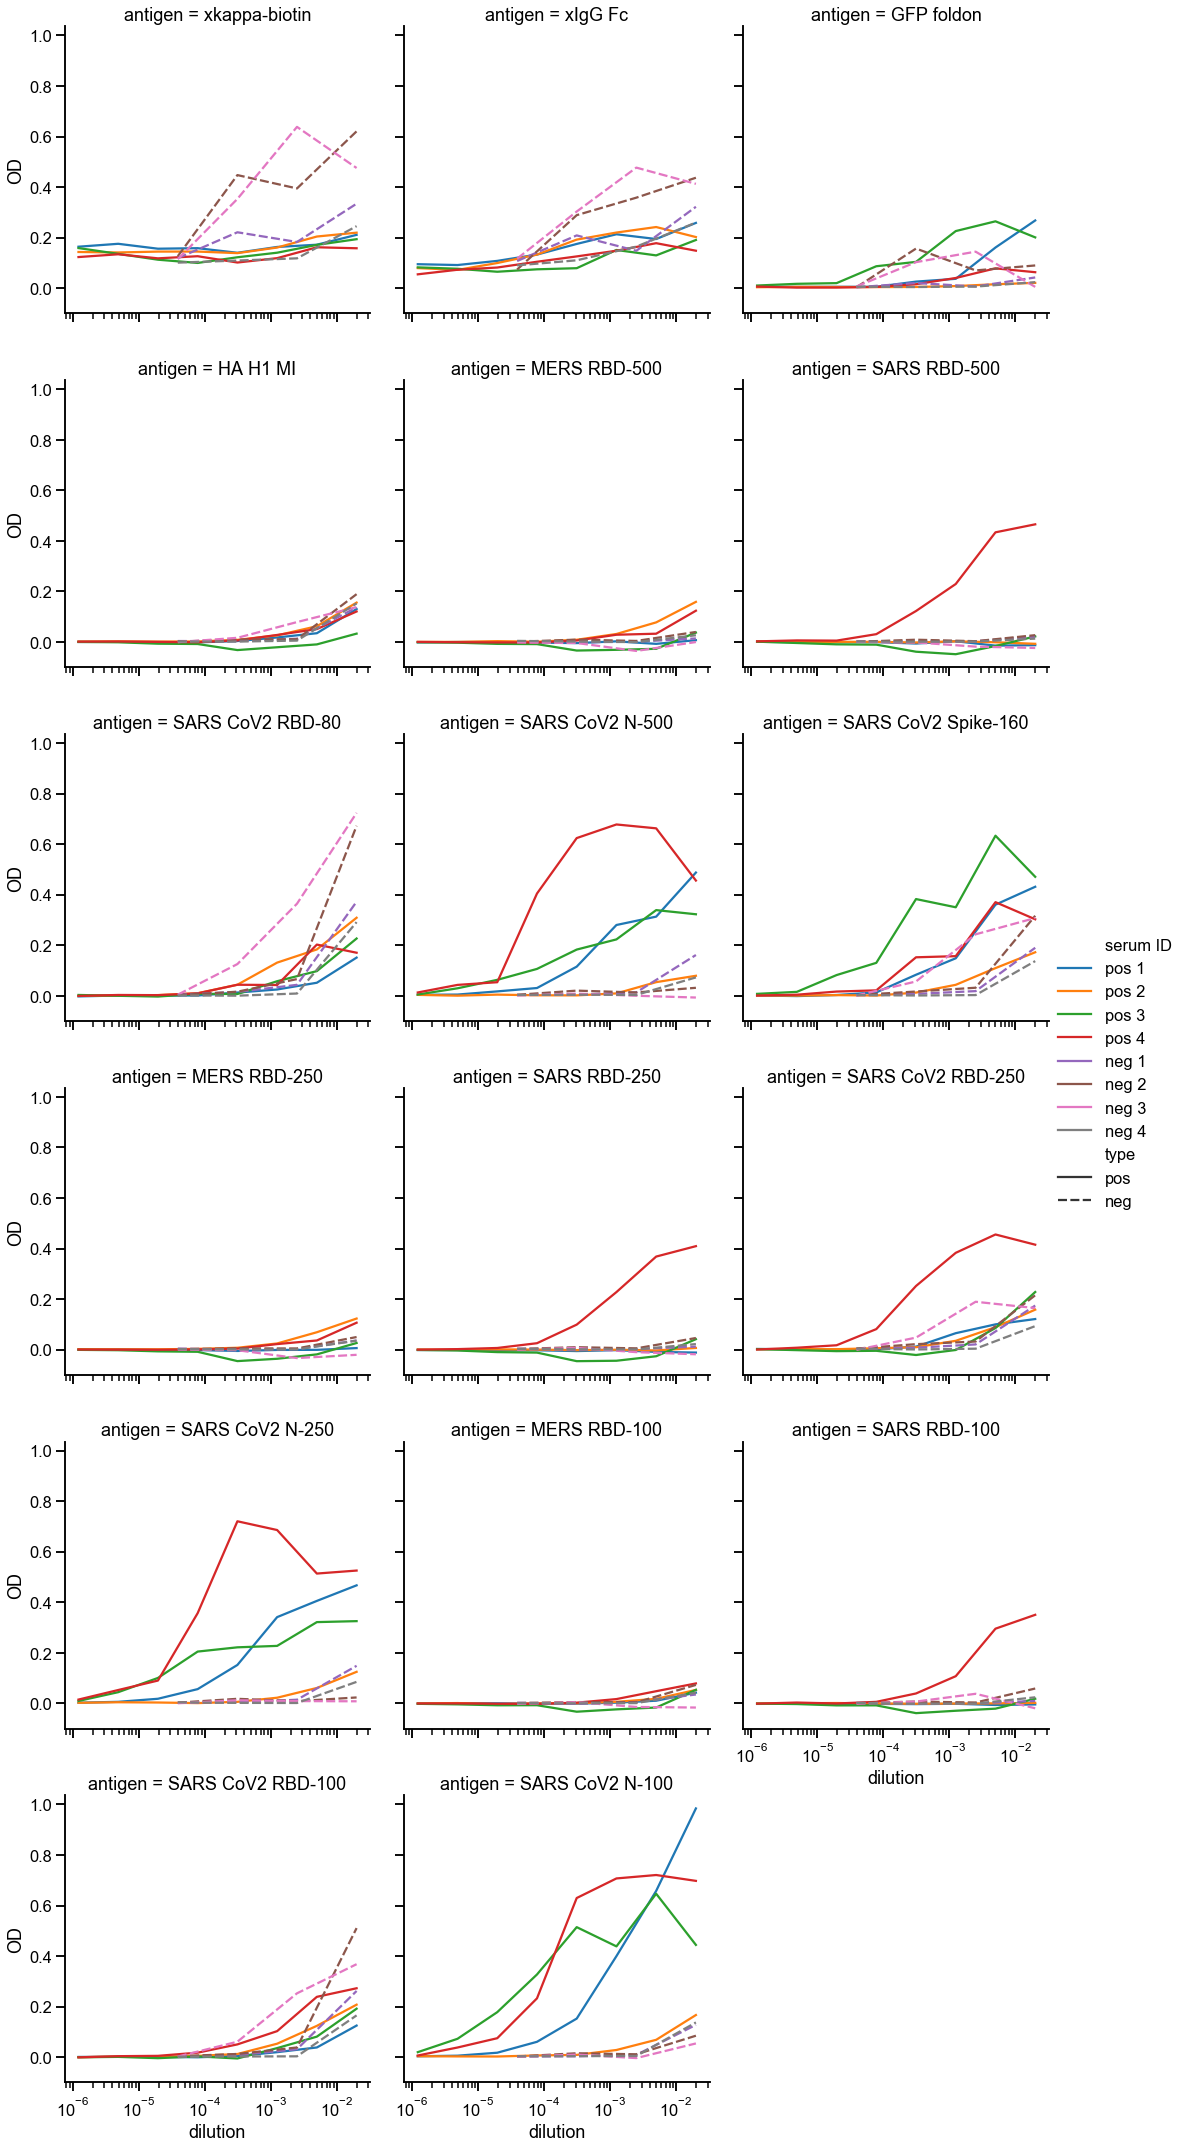

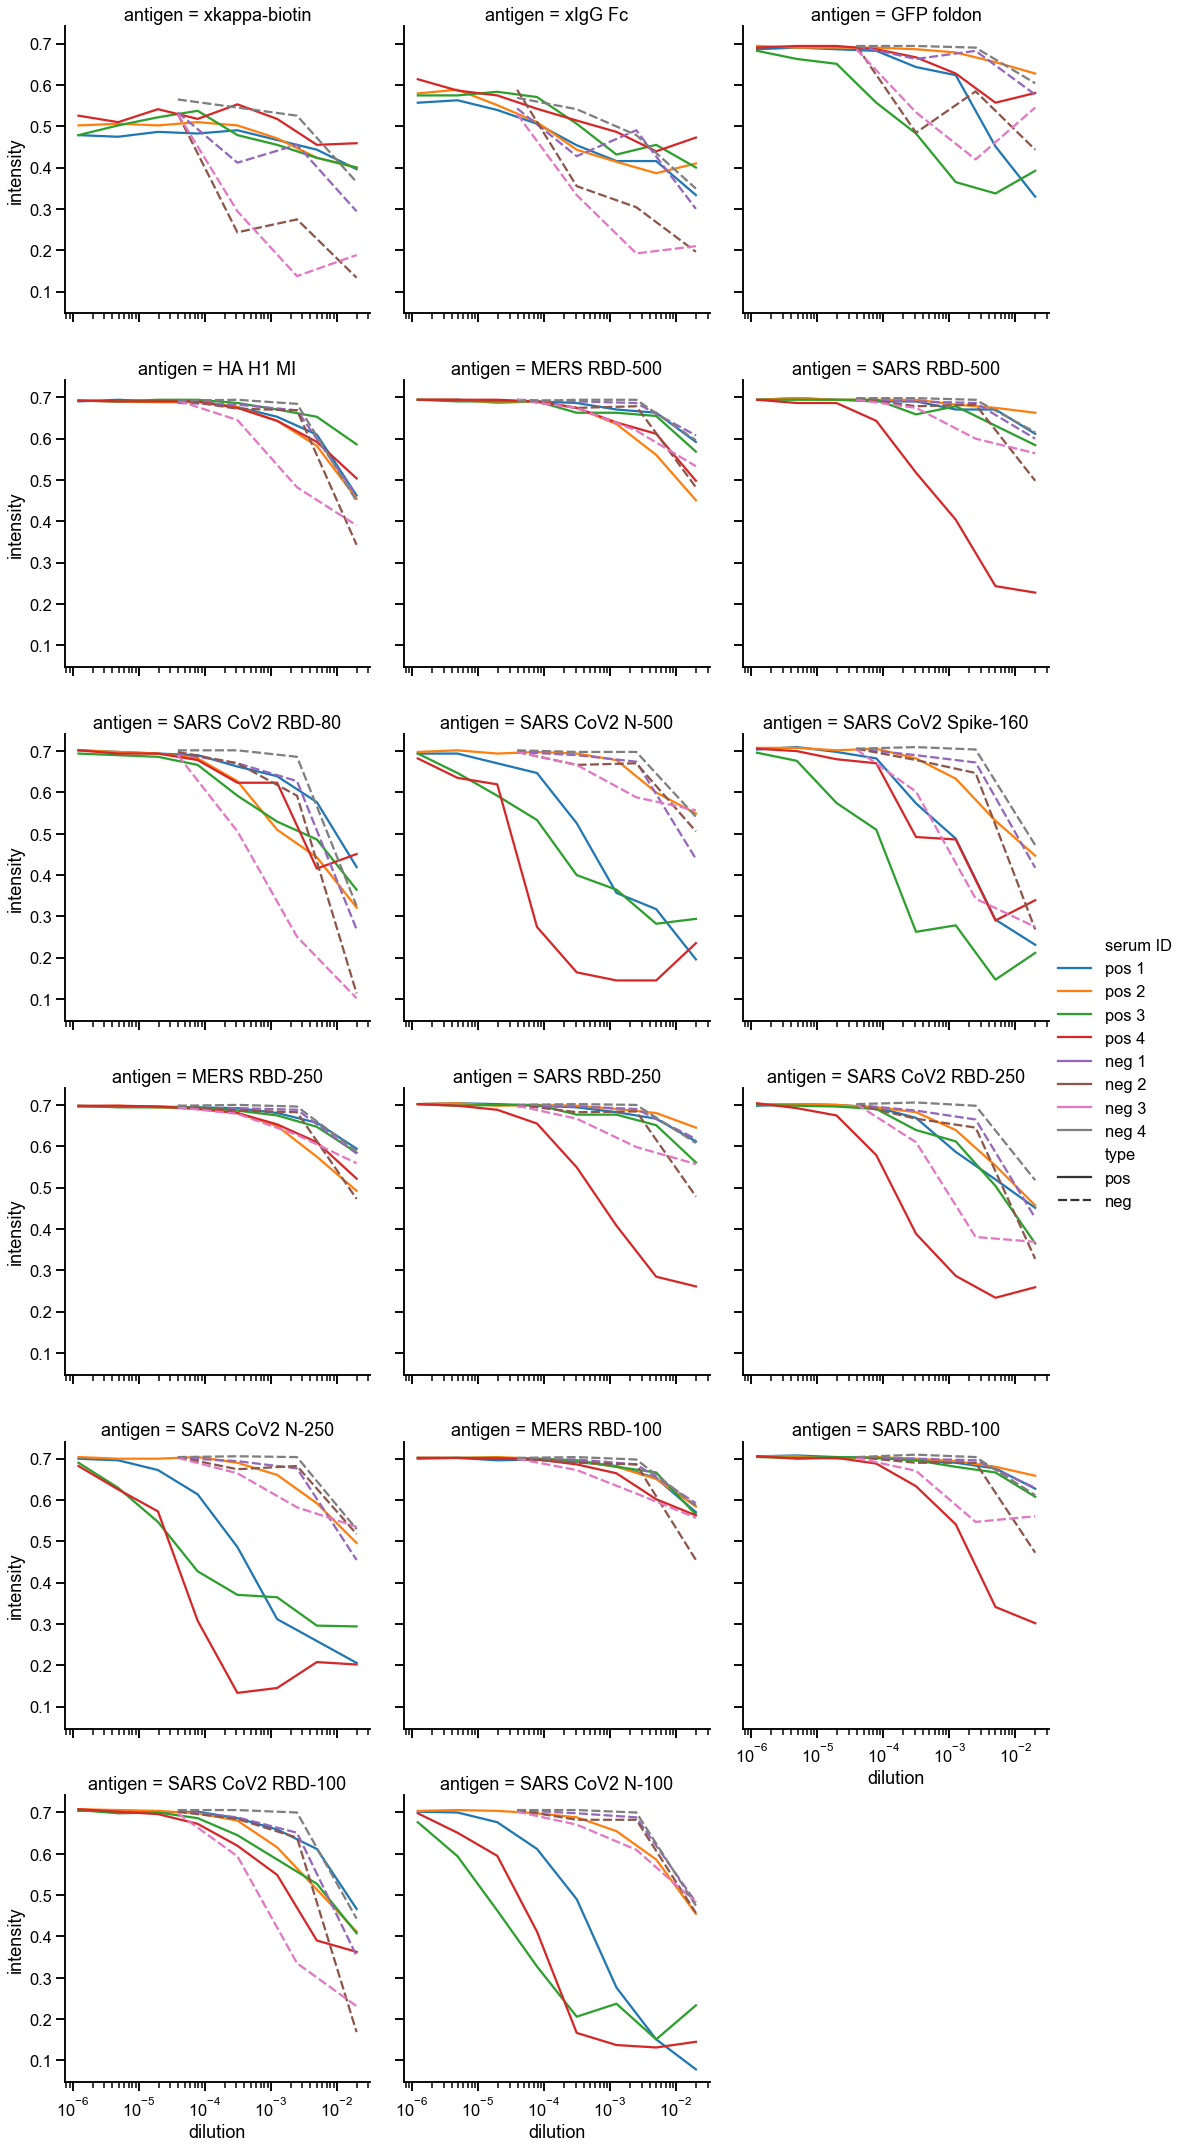

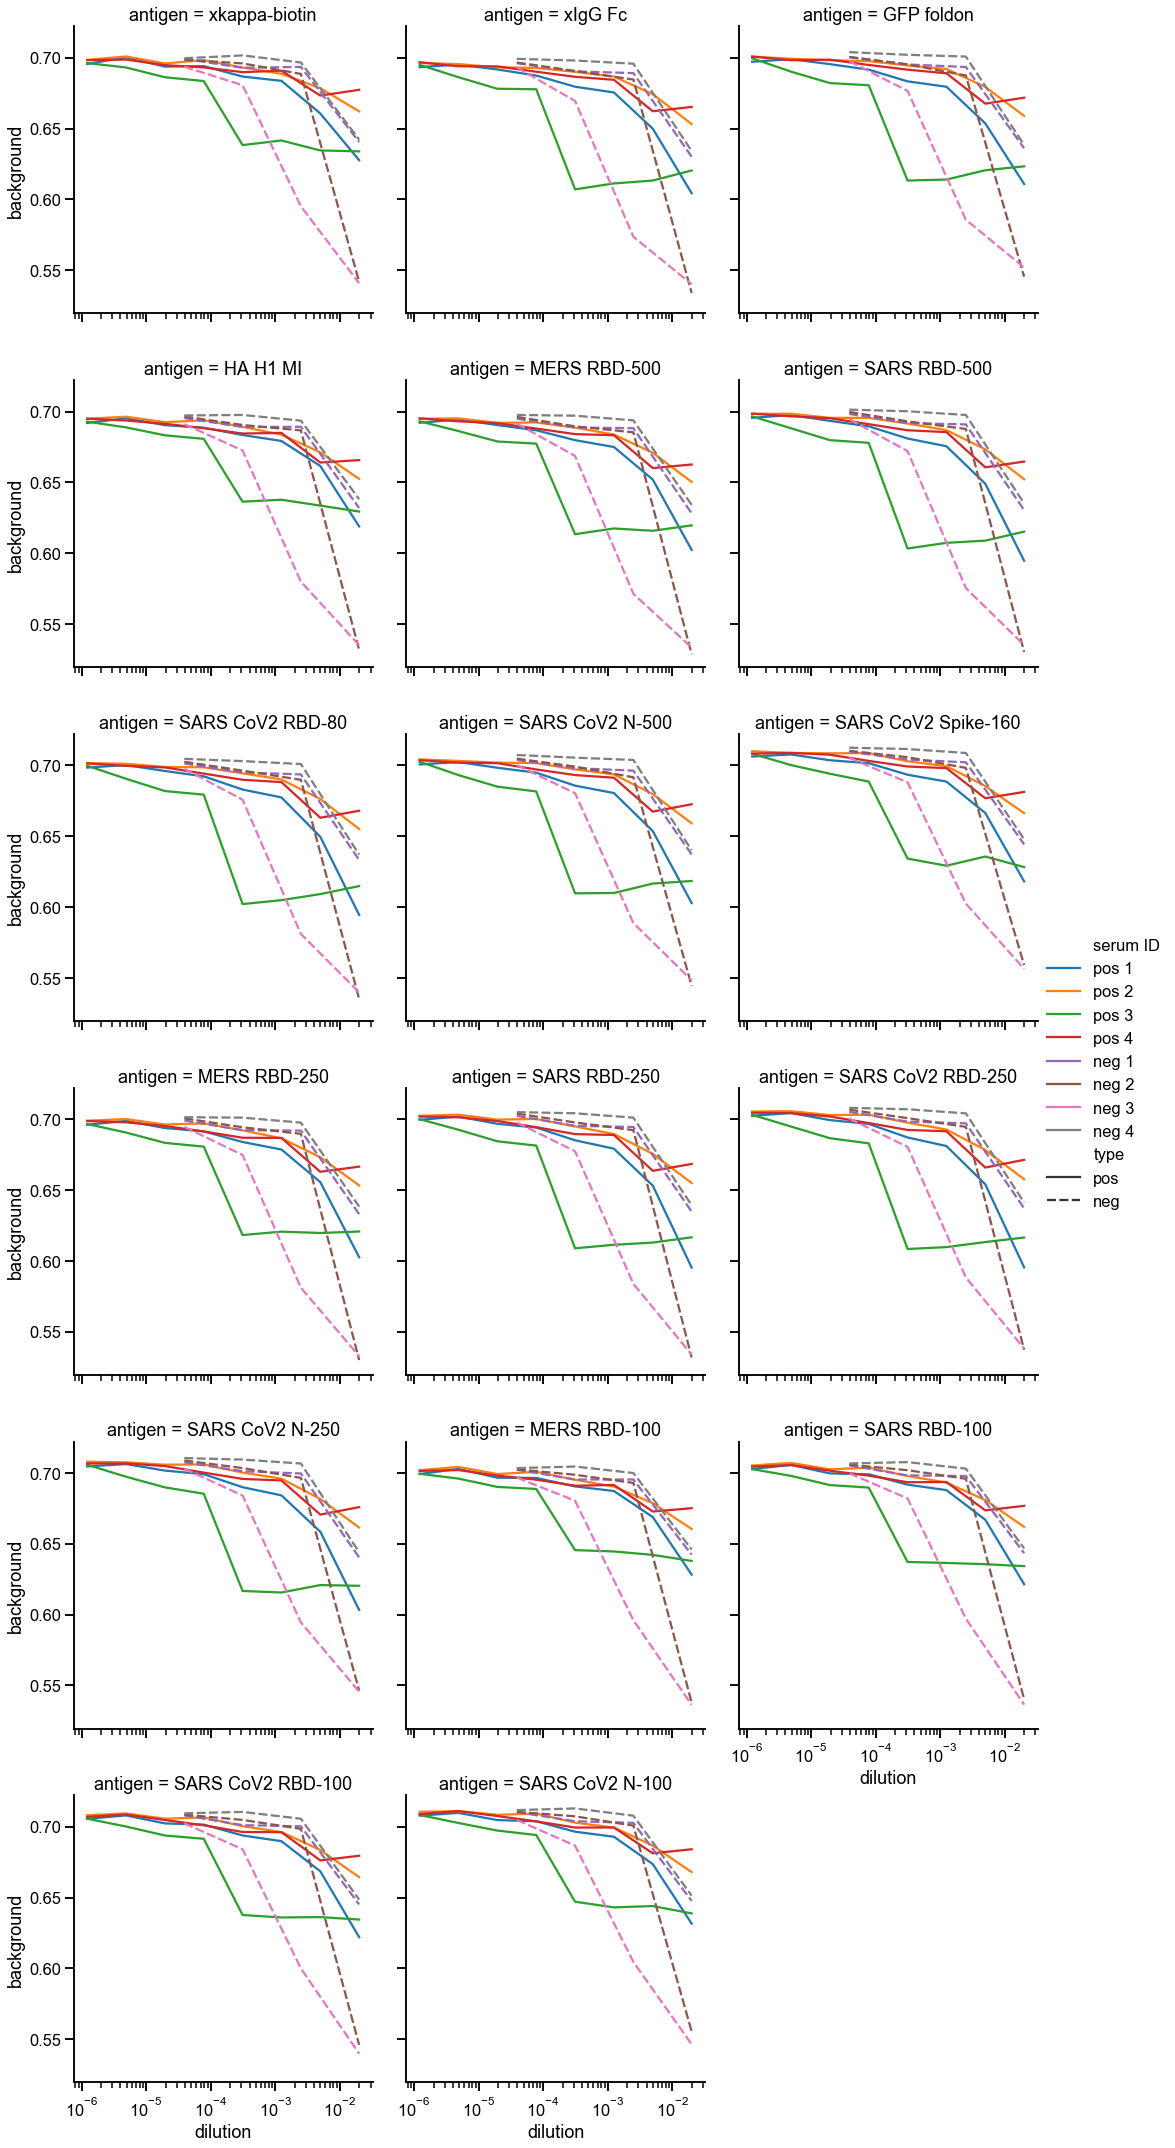

In [148]:
fig_path = os.path.join(data_folder, 'pysero_fit_OD_8_sera_per_ag')
os.makedirs(fig_path, exist_ok=True)
pipeline = 'python'
sera_list = ['pos 1', 'pos 2', 'pos 3', 'pos 4', 'neg 1', 'neg 2', 'neg 3', 'neg 4'] # All +ve sera are affected by comets at some antigens, first 4 negative sera are not affected by comets.
control_ag = ['xkappa-biotin','xIgG Fc', 'GFP foldon']

# selectsera_ctlag = python_df_fix[(python_df_fix['Sera ID'].isin(seralist) & python_df_fix['antigen'].isin(controlag))]
# selectsera_diagag = python_df_fix[(python_df_fix['Sera ID'].isin(seralist) & ~python_df_fix['antigen'].isin(controlag))]

python_sera_df = python_df[python_df['serum ID'].isin(sera_list) & (python_df['pipeline']==pipeline)]
y_list = ["OD", "intensity", "background"]

for y in y_list:
    g = sns.relplot(x="dilution", y=y,
                        hue="serum ID", style = "type", col="antigen", ci=None, 
                         data=python_sera_df, col_wrap=3, estimator=np.nanmedian, kind='line')
    g.set(xscale="log")
    # g.set(xscale="log", ylim=[-0.05, 0.8], xlim=[1E-6, 2E-2])
    plt.savefig(os.path.join(fig_path, '_'.join(['pysero', y + '.jpg'])), dpi=300, bbox_inches='tight')


## Compare pysero and Scienion aross all serum and antigen combinations

In [180]:
fig_path = os.path.join(data_folder, 'python_median_vs_scienion')
os.makedirs(fig_path, exist_ok=True)
y_list = ["OD", "intensity", "background"]
for serum in python_df['serum ID'].unique():
    serum_df = python_df[python_df['serum ID']==serum]
    for y in y_list:
        g = sns.relplot(x="dilution", y=y,
                    hue="pipeline", col="antigen", ci='sd', style='pipeline',
                     data=serum_df, col_wrap=3, estimator=np.mean, kind='line')
        g.set(xscale="log", ylim=[-0.05, 1.2])
        plt.savefig(os.path.join(fig_path, '_'.join([serum, y + '.jpg'])), dpi=300, bbox_inches='tight')
        plt.close()

## Fit curves to above plots

In [154]:
# Compare sera for each antigen
import scipy.optimize as optimization
import itertools

def fourPL(x, A, B, C, D):
    return ((A-D)/(1.0+((x/C)**(B))) + D)
   
def fit2df(df, model, pipeline):
    """fit model to x, y data in dataframe. 
    Return a dataframe with fit x, y for plotting
    """
    sera = df['serum ID'].unique()
    antigens = df['antigen'].unique()
    keys = itertools.product(sera, antigens)
    df_fit = pd.DataFrame(columns=df.columns)
    for serum, antigen in keys:
        print(serum, antigen)
        sub_df = df[(df['serum ID']==serum) & (df['antigen']==antigen) & (df['pipeline']==pipeline)]
        df_fit_temp = pd.DataFrame(columns=df.columns)
        guess = [0, 1, 5e-4, 1]
        xdata = sub_df['dilution'].to_numpy()
        ydata = sub_df['OD'].to_numpy()
        params, params_covariance = optimization.curve_fit(model, xdata, ydata, guess, bounds=(0, np.inf), maxfev=1e5)
        x_input = np.logspace(np.log10(np.min(xdata)), np.log10(np.max(xdata)), 50)
        y_fit = fourPL(x_input, *params)

        df_fit_temp['dilution'] = x_input
        df_fit_temp['OD'] = y_fit
        df_fit_temp['serum ID'] = ' '.join([serum, 'fit'])
        df_fit_temp['antigen'] = antigen
        df_fit_temp['type'] = sub_df['type'].unique()[0]
        df_fit_temp['pipeline'] = pipeline
        df_fit = df_fit.append(df_fit_temp)  
    return df_fit
python_df_fit = fit2df(python_df, fourPL, 'python')

pos 1 xkappa-biotin
pos 1 xIgG Fc
pos 1 GFP foldon
pos 1 HA H1 MI
pos 1 MERS RBD-500
pos 1 SARS RBD-500
pos 1 SARS CoV2 RBD-80
pos 1 SARS CoV2 N-500
pos 1 SARS CoV2 Spike-160
pos 1 MERS RBD-250
pos 1 SARS RBD-250
pos 1 SARS CoV2 RBD-250
pos 1 SARS CoV2 N-250
pos 1 MERS RBD-100
pos 1 SARS RBD-100
pos 1 SARS CoV2 RBD-100
pos 1 SARS CoV2 N-100
pos 2 xkappa-biotin
pos 2 xIgG Fc
pos 2 GFP foldon
pos 2 HA H1 MI
pos 2 MERS RBD-500
pos 2 SARS RBD-500
pos 2 SARS CoV2 RBD-80
pos 2 SARS CoV2 N-500
pos 2 SARS CoV2 Spike-160
pos 2 MERS RBD-250
pos 2 SARS RBD-250
pos 2 SARS CoV2 RBD-250
pos 2 SARS CoV2 N-250
pos 2 MERS RBD-100
pos 2 SARS RBD-100
pos 2 SARS CoV2 RBD-100
pos 2 SARS CoV2 N-100
pos 3 xkappa-biotin
pos 3 xIgG Fc
pos 3 GFP foldon
pos 3 HA H1 MI
pos 3 MERS RBD-500
pos 3 SARS RBD-500
pos 3 SARS CoV2 RBD-80
pos 3 SARS CoV2 N-500
pos 3 SARS CoV2 Spike-160
pos 3 MERS RBD-250
pos 3 SARS RBD-250
pos 3 SARS CoV2 RBD-250
pos 3 SARS CoV2 N-250
pos 3 MERS RBD-100
pos 3 SARS RBD-100
pos 3 SARS CoV2 R

/Users/syuan-mingguo/.conda/envs/serology-COVID19/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


neg 1 MERS RBD-500
neg 1 SARS RBD-500
neg 1 SARS CoV2 RBD-80
neg 1 SARS CoV2 N-500
neg 1 SARS CoV2 Spike-160
neg 1 MERS RBD-250
neg 1 SARS RBD-250
neg 1 SARS CoV2 RBD-250
neg 1 SARS CoV2 N-250
neg 1 MERS RBD-100
neg 1 SARS RBD-100
neg 1 SARS CoV2 RBD-100
neg 1 SARS CoV2 N-100
neg 9 xkappa-biotin
neg 9 xIgG Fc
neg 9 GFP foldon
neg 9 HA H1 MI
neg 9 MERS RBD-500
neg 9 SARS RBD-500
neg 9 SARS CoV2 RBD-80
neg 9 SARS CoV2 N-500
neg 9 SARS CoV2 Spike-160
neg 9 MERS RBD-250
neg 9 SARS RBD-250
neg 9 SARS CoV2 RBD-250
neg 9 SARS CoV2 N-250
neg 9 MERS RBD-100
neg 9 SARS RBD-100
neg 9 SARS CoV2 RBD-100
neg 9 SARS CoV2 N-100
neg 2 xkappa-biotin
neg 2 xIgG Fc
neg 2 GFP foldon
neg 2 HA H1 MI
neg 2 MERS RBD-500
neg 2 SARS RBD-500
neg 2 SARS CoV2 RBD-80
neg 2 SARS CoV2 N-500
neg 2 SARS CoV2 Spike-160
neg 2 MERS RBD-250
neg 2 SARS RBD-250
neg 2 SARS CoV2 RBD-250
neg 2 SARS CoV2 N-250
neg 2 MERS RBD-100
neg 2 SARS RBD-100
neg 2 SARS CoV2 RBD-100
neg 2 SARS CoV2 N-100
neg 10 xkappa-biotin
neg 10 xIgG Fc
n

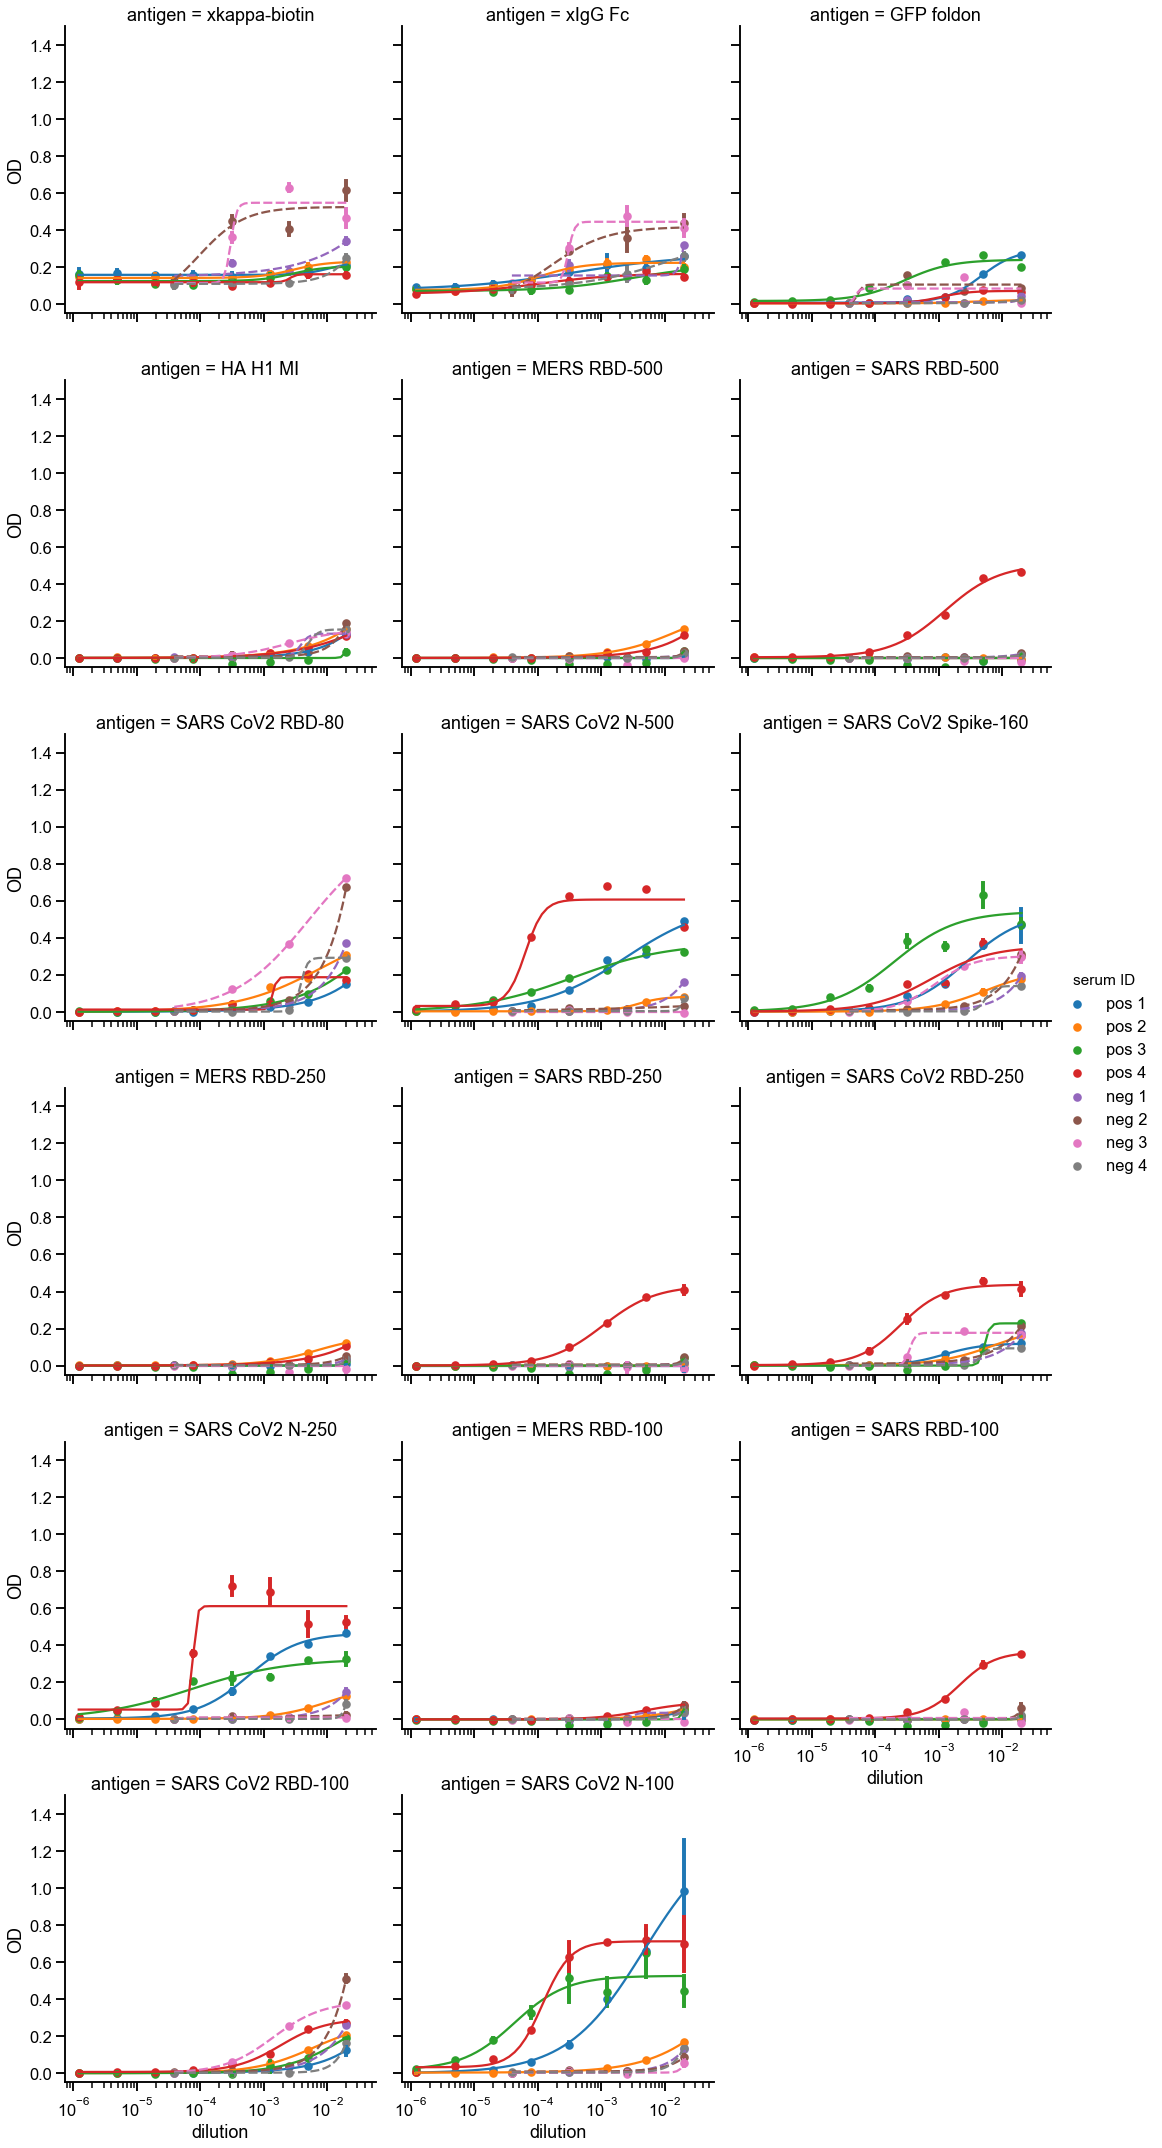

In [157]:
# serum_type = 'Control'
sera_list = ['pos 1', 'pos 2', 'pos 3', 'pos 4', 'neg 1', 'neg 2', 'neg 3', 'neg 4'] 
# sera_list = ['neg ' + str(i) for i in range(11, 16)]
sub_df = python_df[(python_df['pipeline']==pipeline) &
                  python_df['serum ID'].isin(sera_list) ]

g = sns.lmplot(x="dilution", y="OD",
                hue='serum ID', col="antigen", ci='sd',
                 data=sub_df, col_wrap=3, fit_reg=False, x_estimator=np.mean)

sera_list = [' '.join([x, 'fit']) for x in sera_list]
sub_python_df_fit=python_df_fit[(python_df_fit['pipeline']==pipeline) & 
                               python_df_fit['serum ID'].isin(sera_list) ]

for antigen, ax in zip(sub_df['antigen'].unique(), g.axes.flat):
    df_fit = sub_python_df_fit[sub_python_df_fit['antigen']==antigen]
    sns.lineplot(x="dilution", y="OD", hue='serum ID', data=df_fit, style='type', ax=ax, legend=False)
    ax.set(xscale="log", ylim=[-0.05, 1.5])
    
# plt.savefig(os.path.join(fig_path, 'pyseroOD_neg_sera_11_16_fit.jpg'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_path, 'pyseroOD_4_pos_4_neg_sera_fit.jpg'), dpi=300, bbox_inches='tight')

In [142]:
python_df_fit

antigen_row antigen_col        OD well_id          antigen    Sera ID  \
0          NaN         NaN  0.318179     NaN    xkappa-biotin  pos 1 fit   
1          NaN         NaN  0.318179     NaN    xkappa-biotin  pos 1 fit   
2          NaN         NaN  0.318179     NaN    xkappa-biotin  pos 1 fit   
3          NaN         NaN  0.318179     NaN    xkappa-biotin  pos 1 fit   
4          NaN         NaN  0.318179     NaN    xkappa-biotin  pos 1 fit   
..         ...         ...       ...     ...              ...        ...   
15         NaN         NaN       NaN     NaN  SARS CoV2 N-100  blank fit   
16         NaN         NaN       NaN     NaN  SARS CoV2 N-100  blank fit   
17         NaN         NaN       NaN     NaN  SARS CoV2 N-100  blank fit   
18         NaN         NaN       NaN     NaN  SARS CoV2 N-100  blank fit   
19         NaN         NaN  0.158520     NaN  SARS CoV2 N-100  blank fit   

     type  dilution intensity background pipeline  
0     pos  0.000001       NaN        NaN   python  
1     pos  0.000002       NaN        NaN   python  
2     pos  0.000003       NaN        NaN   python  
3     pos  0.000006       NaN        NaN   python  
4     pos  0.000009       NaN        NaN   python  
..    ...       ...       ...        ...      ...  
15  blank       NaN       NaN        NaN   python  
16  blank       NaN       NaN        NaN   python  
17  blank       NaN       NaN        NaN   python  
18  blank       NaN       NaN        NaN   python  
19  blank  0.000000       NaN        NaN   python  

[6800 rows x 11 columns]